In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# 
A few things:

-I've downloaded and compiled mocsy on the /data machines at /data/tjarniko/mocsy, so you need to either append that path or redownload it/ recompile it (no reason probably not to use my download)

-Need to use in_situ T, psu. 

-Pretty good docs are here, I didn't read them the first time around, oops http://ocmip5.ipsl.jussieu.fr/mocsy/

-it only takes 1D arrays, so you need to use np.ravel

-The formulation is like this:

    response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=Pr, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

where I've selected the best optb, optk1k2, optkf options. They're (slightly) different constants in formulations of the carbonate chemistry system. they're pretty similar, esp for your work (probably limited freshwater?)

-silicate and phosphate do affect OmegaA a little bit, but really just a little bit, I wouldn't worry about it. Same with latitude (which again factors into one of the parameterzations)

-atmospheric pressure should be in Patm (i usually say 1 unless I'm calculating it online) 

-depth can be in meters or dbar, I use meters.


In [2]:
import sys
sys.path.append('/data/kramosmu/mocsy')
import mocsy

import numpy as np
import matplotlib.pyplot as plt
import seawater as sw
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr
%matplotlib inline

In [3]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho)

def get_vars(state,ptracer,mask, yind, xind):
    DIC_umolkg = np.ma.masked_array(np.nanmean(ptracer.Tr09[8:,:,yind,xind], axis=0), mask=mask) #umol/kg
    TA_umolkg = np.ma.masked_array(np.nanmean(ptracer.Tr10[8:,:,yind,xind], axis=0), mask=mask) #umol/kg
    density = np.ma.masked_array(call_rho(0,state,slice(0,104),xind,yind).data, mask=mask)
    DIC = (density*DIC_umolkg/1000)
    TA = (density*TA_umolkg/1000)
    S =  np.ma.masked_array(np.nanmean(state.S[8:,:,yind,xind], axis=0), mask=mask)
    T =  np.ma.masked_array(np.nanmean(state.Temp[8:,:,yind,xind], axis=0), mask=mask)
    return(DIC, TA, S, T)

In [9]:
grid_file_A = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/gridGlob.nc' 
grid_file_Anoc = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/gridGlob.nc' 

ptrARGO = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/ptracersGlob.nc')
ptrARGOnoc = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/ptracersGlob.nc')
stateARGO = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/stateGlob.nc')
stateARGOnoc = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/stateGlob.nc')
gridARGO = xr.open_dataset(grid_file_A)
gridARGOnoc = xr.open_dataset(grid_file_Anoc)

with nc.Dataset(grid_file_A, 'r') as nbl:
    hFacA = nbl.variables['HFacC'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)

with nc.Dataset(grid_file_Anoc, 'r') as nbl:
    hFacA = nbl.variables['HFacC'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCAnoc = np.ma.getmask(hfac)

grid_file_B = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/gridGlob.nc' 
grid_file_Bnoc = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/04_Bar03_No_Cny_Path/gridGlob.nc' 
ptrPATH = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/ptracersGlob.nc')
ptrPATHnoc = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/04_Bar03_No_Cny_Path/ptracersGlob.nc')
statePATH = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/stateGlob.nc')
statePATHnoc = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/04_Bar03_No_Cny_Path/stateGlob.nc')
gridPATH = xr.open_dataset(grid_file_B)
gridPATHnoc = xr.open_dataset(grid_file_Bnoc)

with nc.Dataset(grid_file_B, 'r') as nbl:
    hFacB = nbl.variables['HFacC'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)

with nc.Dataset(grid_file_Bnoc, 'r') as nbl:
    hFacB = nbl.variables['HFacC'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCBnoc = np.ma.getmask(hfac)


In [5]:
# Stations x,y indices A for ARGO, B for Pathways
yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    

linestyles = ['-','--',':','-.']
st_names=['S1','S2','S3','S4']

min pH anom at -112.500000 m of S1 is -0.945455 
min pH anom at -87.500000 m of S2 is -0.065785 
min pH anom at -82.500000 m of S3 is -0.040375 
min pH anom at -17.500000 m of S4 is -0.034379 


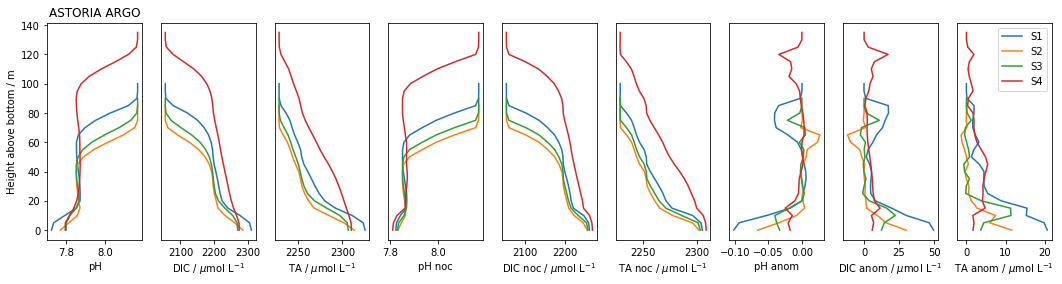

In [7]:
# Make profiles at stations S1, S2, S3, S4, MASKED USING NO-CANYON HFACC

fig, (ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(1,9, figsize=(18,4))

for xind, yind, st in zip(xindA, yindA, st_names):
    
    DIC, TA, S, T = get_vars(stateARGO,ptrARGO,maskCAnoc[:,yind,xind], yind, xind)
    DIC_noc, TA_noc, S_noc, T_noc = get_vars(stateARGOnoc,ptrARGOnoc,maskCAnoc[:,yind,xind], yind, xind)
    
    depth = np.ma.masked_array(gridARGO.Z[:], mask=maskCA[:,yind,xind])
    depth_noc = np.ma.masked_array(gridARGOnoc.Z[:], mask=maskCAnoc[:,yind,xind])
    
    Surf_p = np.ones_like(DIC)
    zero  = np.zeros_like(DIC)
    
    response_tup = mocsy.mvars(temp=T, sal=S, alk=TA, dic=DIC, 
                               sil=zero, phos=zero, patm=Surf_p, depth=depth_noc, lat=zero, 
                               optcon='mol/m3', optt='Tinsitu', optp='m',
                               optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
    
    response_tup_noc = mocsy.mvars(temp=T_noc, sal=S_noc, alk=TA_noc, dic=DIC_noc, 
                                   sil=zero, phos=zero, patm=Surf_p, depth=depth_noc, lat=zero, 
                                   optcon='mol/m3', optt='Tinsitu', optp='m',
                                   optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH_noc,pco2_noc,fco2_noc,co2_noc,hco3_noc,co3_noc,OmegaA_noc,OmegaC_noc,BetaD_noc,DENis_noc,p_noc,Tis_noc = \
    response_tup_noc
    
    pH_anom = pH-pH_noc
    DIC_anom = DIC-DIC_noc
    TA_anom = TA-TA_noc
    
    ax0.plot(pH,depth_noc-np.nanmin(depth_noc), label=st)
    ax1.plot(DIC,depth_noc-np.nanmin(depth_noc), label=st)
    ax2.plot(TA,depth_noc-np.nanmin(depth_noc), label=st)
    ax3.plot(pH_noc,depth_noc-np.nanmin(depth_noc), label=st)
    ax4.plot(DIC_noc,depth_noc-np.nanmin(depth_noc), label=st)
    ax5.plot(TA_noc,depth_noc-np.nanmin(depth_noc), label=st)
    ax6.plot(pH_anom,depth_noc-np.nanmin(depth_noc), label=st)
    ax7.plot(DIC_anom,depth_noc-np.nanmin(depth_noc), label=st)
    ax8.plot(TA_anom,depth_noc-np.nanmin(depth_noc), label=st)
    ind_min = np.argmin(pH_anom)
    print('min pH anom at %f m of %s is %f ' %(depth[ind_min],st,pH_anom[ind_min]))    

for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    ax.set_yticks([])
ax0.set_ylabel('Height above bottom / m')
ax0.set_xlabel('pH')
ax1.set_xlabel('DIC / $\mu$mol L$^{-1}$')
ax2.set_xlabel('TA / $\mu$mol L$^{-1}$')
ax3.set_xlabel('pH noc')
ax4.set_xlabel('DIC noc / $\mu$mol L$^{-1}$')
ax5.set_xlabel('TA noc / $\mu$mol L$^{-1}$')
ax6.set_xlabel('pH anom')
ax7.set_xlabel('DIC anom / $\mu$mol L$^{-1}$')
ax8.set_xlabel('TA anom / $\mu$mol L$^{-1}$')
ax0.set_title('ASTORIA ARGO')
ax8.legend(loc=0)

min pH anom at -162.500000 m of S1 is -0.040483 
min pH anom at -157.500000 m of S2 is -0.031157 
min pH anom at -152.500000 m of S3 is -0.017785 
min pH anom at -177.500000 m of S4 is -0.017354 


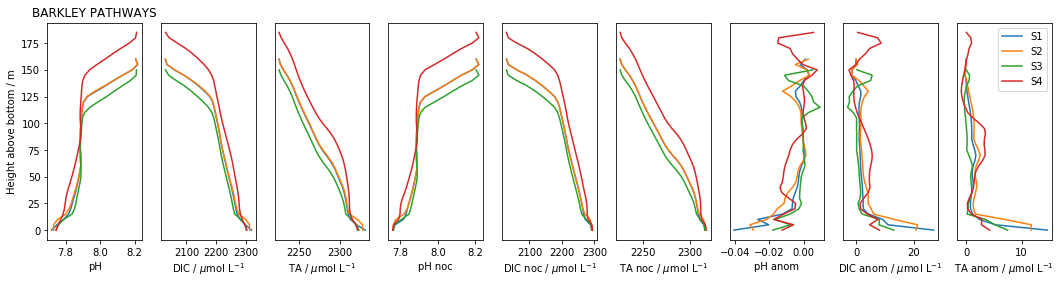

In [10]:
# Make profiles at stations S1, S2, S3, S4, MASKED USING NO-CANYON HFACC

fig, (ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(1,9, figsize=(18,4))

for xind, yind, st in zip(xindB, yindB, st_names):
    
    DIC, TA, S, T = get_vars(statePATH,ptrPATH,maskCBnoc[:,yind,xind], yind, xind)
    DIC_noc, TA_noc, S_noc, T_noc = get_vars(statePATHnoc,ptrPATHnoc,maskCBnoc[:,yind,xind], yind, xind)
    
    depth = np.ma.masked_array(gridPATH.Z[:], mask=maskCB[:,yind,xind])
    depth_noc = np.ma.masked_array(gridPATHnoc.Z[:], mask=maskCBnoc[:,yind,xind])
    
    Surf_p = np.ones_like(DIC)
    zero  = np.zeros_like(DIC)
    
    response_tup = mocsy.mvars(temp=T, sal=S, alk=TA, dic=DIC, 
                               sil=zero, phos=zero, patm=Surf_p, depth=depth_noc, lat=zero, 
                               optcon='mol/m3', optt='Tinsitu', optp='m',
                               optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
    
    response_tup_noc = mocsy.mvars(temp=T_noc, sal=S_noc, alk=TA_noc, dic=DIC_noc, 
                                   sil=zero, phos=zero, patm=Surf_p, depth=depth_noc, lat=zero, 
                                   optcon='mol/m3', optt='Tinsitu', optp='m',
                                   optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH_noc,pco2_noc,fco2_noc,co2_noc,hco3_noc,co3_noc,OmegaA_noc,OmegaC_noc,BetaD_noc,DENis_noc,p_noc,Tis_noc = \
    response_tup_noc
    
    pH_anom = pH-pH_noc
    DIC_anom = DIC-DIC_noc
    TA_anom = TA-TA_noc
    
    ax0.plot(pH,depth_noc-np.nanmin(depth_noc), label=st)
    ax1.plot(DIC,depth_noc-np.nanmin(depth_noc), label=st)
    ax2.plot(TA,depth_noc-np.nanmin(depth_noc), label=st)
    ax3.plot(pH_noc,depth_noc-np.nanmin(depth_noc), label=st)
    ax4.plot(DIC_noc,depth_noc-np.nanmin(depth_noc), label=st)
    ax5.plot(TA_noc,depth_noc-np.nanmin(depth_noc), label=st)
    ax6.plot(pH_anom,depth_noc-np.nanmin(depth_noc), label=st)
    ax7.plot(DIC_anom,depth_noc-np.nanmin(depth_noc), label=st)
    ax8.plot(TA_anom,depth_noc-np.nanmin(depth_noc), label=st)
    
    ind_min = np.argmin(pH_anom)
    print('min pH anom at %f m of %s is %f ' %(depth[ind_min],st,pH_anom[ind_min]))    

for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    ax.set_yticks([])
ax0.set_ylabel('Height above bottom / m')
ax0.set_xlabel('pH')
ax1.set_xlabel('DIC / $\mu$mol L$^{-1}$')
ax2.set_xlabel('TA / $\mu$mol L$^{-1}$')
ax3.set_xlabel('pH noc')
ax4.set_xlabel('DIC noc / $\mu$mol L$^{-1}$')
ax5.set_xlabel('TA noc / $\mu$mol L$^{-1}$')
ax6.set_xlabel('pH anom')
ax7.set_xlabel('DIC anom / $\mu$mol L$^{-1}$')
ax8.set_xlabel('TA anom / $\mu$mol L$^{-1}$')
ax0.set_title('BARKLEY PATHWAYS')
ax8.legend(loc=0)